# 주제: 영화리뷰 텍스트 감상분석하기

## 데이터
네이버 영화리뷰 텍스트  
출처: https://github.com/e9t/nsmc  
예시:  
- raw data  
 {   
    "review_id": "9571964",  
    "movie_id": "100022",  
    "author": "spro****",  
    "review": "몇번을 봐도 정말 대작이다...내 인생의 영화",  
    "rating": "10",  
    "date": "15.01.07"  
  },  
- 가공된 train, test data  
7612498	손현주 짱	1  
3653446	훈훈한 내용이지만 스토리가 다소 억지스럽고 부족하다.	0  
9649094	무언가 잊고 살았다는 느낌을 준 영화 이제 생각을 좀 바꿔야 할거 같음	1  
5440565	또 뻔한결말 또 뻔한 시걸의 영화	0  
10081576	혼자 북치고 장구치다가 관객 우롱하면서 끝난다.	0  
5802318	천하의 슈렉도 속편이 거듭되다보니 힘이 떨어지는군	0  
- 즉, 긍정이면 1, 부정이면 0임  

## 활동
1. 학습한 임베딩 레이어 분석
2. 한국어 Word2Vec 임베딩 활용

## 목표
1. 3가지 이상의 모델이 성공적으로 시도
2. gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩 비교 분석
3. 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성

## (1) 라이브러리 및 데이터 불러오기

In [203]:
import pandas as pd
import konlpy
import gensim
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import tensorflow as tf
import matplotlib.pyplot as plt


print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [204]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## (2) 데이터로더 구성
### `data_loader` 에 있어야할 내용들  
- **데이터의 중복 제거**  
- **NaN 결측치 제거**  
- **한국어 토크나이저로 토큰화**  
- **불용어(Stopwords) 제거**  
- **사전`word_to_index` 구성**  
- **텍스트 스트링을 사전 인덱스 스트링으로 변환**  
- **`X_train`, `y_train`, `X_test`, `y_test`, `word_to_index` 리턴**  

In [205]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return np.array(X_train), np.array(list(train_data['label'])), np.array(X_test), np.array(list(test_data['label'])), word_to_index

In [206]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print(f'train data 개수: {len(X_train)}, test data 개수: {len(X_test)}')

train data 개수: 146182, test data 개수: 49157


/tmp/ipykernel_47/3137187504.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(X_train), np.array(list(train_data['label'])), np.array(X_test), np.array(list(test_data['label'])), word_to_index


In [207]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [208]:
# 단어 인덱스 리스트 벡터로 변환해 주는 함수 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [209]:
# 제대로 디코딩 되었는지 확인하기
print(X_train[4])
print(get_decoded_sentence(X_train[4], index_to_word))
print('라벨: ', y_train[4])  # 4번째 리뷰데이터의 라벨

[2, 8894, 1108, 52, 2832, 60, 5, 14, 2758, 41, 1188, 35, 351, 42, 22, 40, 60, 2, 2, 427, 3102, 1766, 6]
익살 스런 연기 돋보였 던 영화 ! 스파이더맨 에서 늙 어 보이 기 만 했 던 <UNK> <UNK> 너무나 이뻐 보였 다
라벨:  1


## (3) 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포  
- 적절한 최대 문장 길이 지정  
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가  

In [210]:
# 데이터 확인
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))
print('3번째 리뷰 문장 길이: ', len(X_train[2]))
print('4번째 리뷰 문장 길이: ', len(X_train[3]))
print('5번째 리뷰 문장 길이: ', len(X_train[4]))

1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17
3번째 리뷰 문장 길이:  3
4번째 리뷰 문장 길이:  13
5번째 리뷰 문장 길이:  23


리뷰의 최대 길이 : 116
리뷰의 평균 길이 : 15.98170773419436


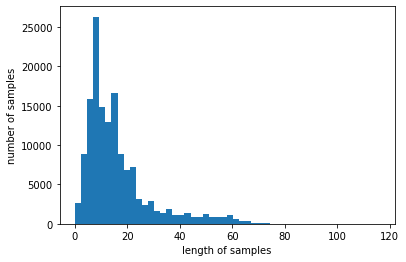

In [211]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [212]:
# 적절한 최대 문장 길이 지정
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {:.3f}%가 maxlen 설정값 이내에 포함됩니다. '.format((np.sum(num_tokens < max_tokens) / len(num_tokens))*100))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 93.430%가 maxlen 설정값 이내에 포함됩니다. 


In [213]:
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [214]:
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
X_train_post = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test_post = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train_post.shape)

(146182, 41)


In [215]:
print(X_train[0])
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0  32  74 919   4   4
  39 228  20  33 748]
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 아 더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [216]:
print(X_train_post[0])
print(get_decoded_sentence(X_train_post[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0  32  74 919   4   4
  39 228  20  33 748]
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 아 더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


-> padding을 pre와 post로 설정한 차이가 이렇게 생겼다는 것을 알 수 있다. RNN에서 일반적으로 더 성능이 좋게 나온다는 pre를 이용할 것이다.

## (4) 모델 구성 및 validation set 구성

In [217]:
print(X_train.shape)

# validation set 3만건 분리
X_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 약 11만건
partial_X_train = X_train[30000:]  
partial_y_train = y_train[30000:]

print(X_val.shape)
print(y_val.shape)
print(partial_X_train.shape)
print(partial_y_train.shape)

(146182, 41)
(30000, 41)
(30000,)
(116182, 41)
(116182,)


### 1. model1 : GlobalMaxPooling1D 만 사용하기

In [218]:
vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(tf.keras.layers.GlobalMaxPooling1D()) 
model1.add(tf.keras.layers.Dense(8, activation='relu'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

model1.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_15 (Glo (None, 16)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


### 2. model2: RNN-LSTM 만 사용하기

In [219]:
vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.LSTM(16)) 
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

model2.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
lstm_16 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_44 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 9         
Total params: 162,257
Trainable params: 162,257
Non-trainable params: 0
_________________________________________________________________


### 3. model3: Conv1D 만 사용하기

In [220]:
vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(tf.keras.layers.Conv1D(16, 3, activation='relu'))
model3.add(tf.keras.layers.Dense(8, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

model3.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
dense_46 (Dense)             (None, None, 8)           136       
_________________________________________________________________
dense_47 (Dense)             (None, None, 1)           9         
Total params: 160,929
Trainable params: 160,929
Non-trainable params: 0
_________________________________________________________________


## (5) 모델 훈련 개시

### 1. model1

In [221]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history1 = model1.fit(partial_X_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
227/227 [==============================] - 1s 4ms/step - loss: 0.6043 - accuracy: 0.7222 - val_loss: 0.4673 - val_accuracy: 0.8170
Epoch 2/10
227/227 [==============================] - 1s 4ms/step - loss: 0.3929 - accuracy: 0.8380 - val_loss: 0.3653 - val_accuracy: 0.8386
Epoch 3/10
227/227 [==============================] - 1s 4ms/step - loss: 0.3285 - accuracy: 0.8624 - val_loss: 0.3511 - val_accuracy: 0.8440
Epoch 4/10
227/227 [==============================] - 1s 4ms/step - loss: 0.2985 - accuracy: 0.8766 - val_loss: 0.3514 - val_accuracy: 0.8471
Epoch 5/10
227/227 [==============================] - 1s 4ms/step - loss: 0.2770 - accuracy: 0.8876 - val_loss: 0.3563 - val_accuracy: 0.8481
Epoch 6/10
227/227 [==============================] - 1s 4ms/step - loss: 0.2597 - accuracy: 0.8959 - val_loss: 0.3633 - val_accuracy: 0.8467
Epoch 7/10
227/227 [==============================] - 1s 4ms/step - loss: 0.2448 - accuracy: 0.9030 - val_loss: 0.3722 - val_accuracy: 0.8454
Epoch 

### 2. model2

In [222]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history2 = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
227/227 [==============================] - 3s 8ms/step - loss: 0.4891 - accuracy: 0.7688 - val_loss: 0.3610 - val_accuracy: 0.8447
Epoch 2/10
227/227 [==============================] - 1s 6ms/step - loss: 0.3401 - accuracy: 0.8560 - val_loss: 0.3506 - val_accuracy: 0.8459
Epoch 3/10
227/227 [==============================] - 1s 6ms/step - loss: 0.3160 - accuracy: 0.8677 - val_loss: 0.3416 - val_accuracy: 0.8539
Epoch 4/10
227/227 [==============================] - 1s 6ms/step - loss: 0.3013 - accuracy: 0.8748 - val_loss: 0.3465 - val_accuracy: 0.8514
Epoch 5/10
227/227 [==============================] - 1s 6ms/step - loss: 0.2896 - accuracy: 0.8802 - val_loss: 0.3472 - val_accuracy: 0.8502
Epoch 6/10
227/227 [==============================] - 1s 6ms/step - loss: 0.2795 - accuracy: 0.8854 - val_loss: 0.3523 - val_accuracy: 0.8500
Epoch 7/10
227/227 [==============================] - 1s 6ms/step - loss: 0.2696 - accuracy: 0.8904 - val_loss: 0.3578 - val_accuracy: 0.8477
Epoch 

### 3. model3

In [223]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history3 = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
227/227 [==============================] - 2s 6ms/step - loss: 0.6674 - accuracy: 0.5575 - val_loss: 0.6494 - val_accuracy: 0.5705
Epoch 2/10
227/227 [==============================] - 1s 5ms/step - loss: 0.6464 - accuracy: 0.5759 - val_loss: 0.6466 - val_accuracy: 0.5713
Epoch 3/10
227/227 [==============================] - 1s 5ms/step - loss: 0.6433 - accuracy: 0.5767 - val_loss: 0.6455 - val_accuracy: 0.5721
Epoch 4/10
227/227 [==============================] - 1s 6ms/step - loss: 0.6420 - accuracy: 0.5770 - val_loss: 0.6449 - val_accuracy: 0.5769
Epoch 5/10
227/227 [==============================] - 1s 5ms/step - loss: 0.6405 - accuracy: 0.5788 - val_loss: 0.6447 - val_accuracy: 0.5772
Epoch 6/10
227/227 [==============================] - 1s 6ms/step - loss: 0.6395 - accuracy: 0.5783 - val_loss: 0.6449 - val_accuracy: 0.5775
Epoch 7/10
227/227 [==============================] - 1s 5ms/step - loss: 0.6385 - accuracy: 0.5804 - val_loss: 0.6444 - val_accuracy: 0.5777
Epoch 

## (6) Loss, Accuracy 그래프 시각화

### 1. model1의 loss, accracy

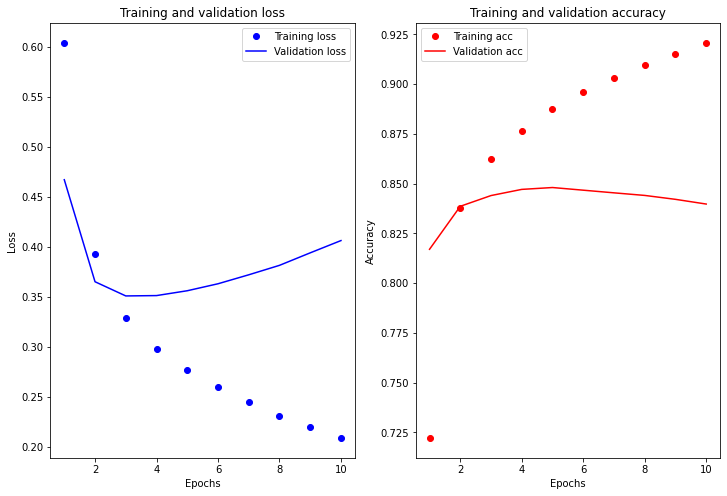

In [224]:
history1_dict = history1.history

acc = history1_dict['accuracy']
val_acc = history1_dict['val_accuracy']
loss = history1_dict['loss']
val_loss = history1_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 2. model2의 loss, accracy

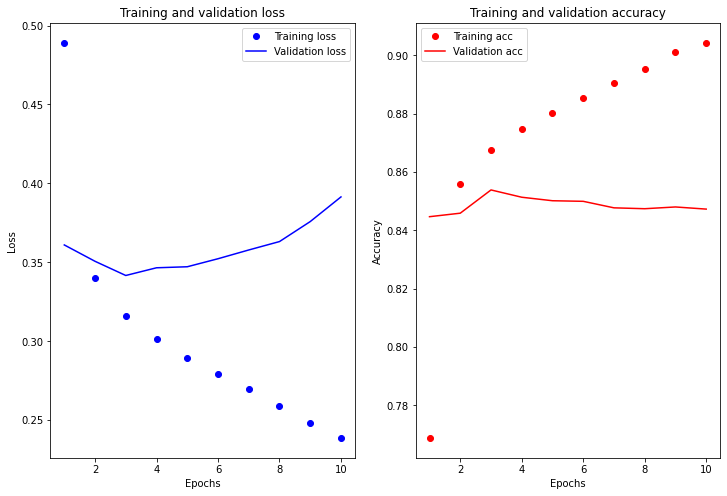

In [225]:
history2_dict = history2.history

acc = history2_dict['accuracy']
val_acc = history2_dict['val_accuracy']
loss = history2_dict['loss']
val_loss = history2_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 3. model3의 loss, accracy

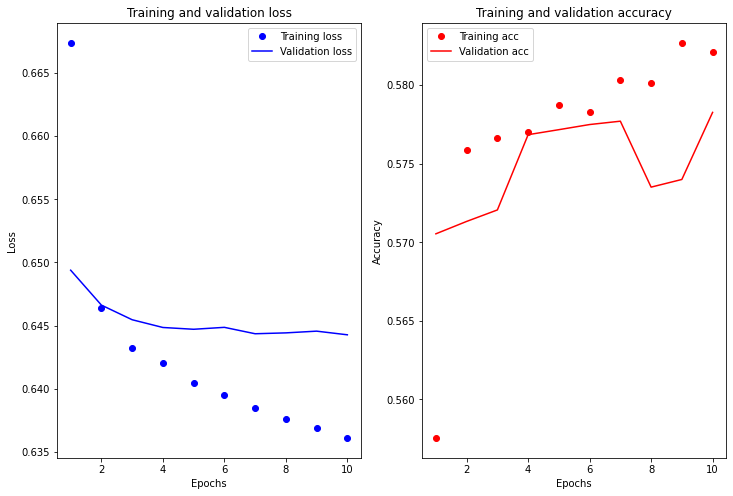

In [226]:
history3_dict = history3.history

acc = history3_dict['accuracy']
val_acc = history3_dict['val_accuracy']
loss = history3_dict['loss']
val_loss = history3_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

-> 세 모델 모두 오버피팅이 심하게 된 것을 확인할 수 있다.

## (7) 학습된 Embedding 레이어 분석
가장 val_acc가 높았던 model2의 임베딩 레이어를 분석할 것이다.

In [227]:
embedding_layer = model2.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [229]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_project.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(특수문자 4개는 제외)만큼의 워드 벡터를 파일에 기록
vectors = model2.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [230]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors.similar_by_word("행복")

[('소주', 0.9653317928314209),
 ('대강', 0.9633067846298218),
 ('깎아내리', 0.9623518586158752),
 ('강렬', 0.9598811268806458),
 ('웰', 0.9595000147819519),
 ('완벽', 0.9584910869598389),
 ('감탄', 0.9565570950508118),
 ('이루어지', 0.9525348544120789),
 ('놓치', 0.9512445330619812),
 ('깔끔', 0.949151873588562)]

In [231]:
word_vectors.similar_by_word("사랑")

[('이루어지', 0.9653973579406738),
 ('스칼렛', 0.9635707139968872),
 ('깔끔', 0.962714433670044),
 ('사라질', 0.9558111429214478),
 ('기발', 0.9549036622047424),
 ('진실', 0.9548484086990356),
 ('로즈', 0.9517953395843506),
 ('나무랄', 0.9464111924171448),
 ('행복', 0.9449795484542847),
 ('재미있', 0.9447473287582397)]

-> 단어 간의 연관성이 크게 두드러 보이지는 않는 것 같다. 성능 개선을 위해 Word2Vec 임베딩을 사용할 것이다.

## (8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [232]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector.shape

(100,)

In [233]:
vector = word2vec.wv['사랑']
print(vector)

[ 3.2565942  -0.85421413 -3.6964011   1.0956469   0.599815   -1.9681435
  0.32379073 -1.0716053  -1.1776937   2.0442047   2.2501915  -2.7868037
 -2.702359   -0.9775915  -0.12478333  0.28235647  0.77683175 -1.5393747
  2.0879042  -5.444462   -4.931412    0.8532094   0.11118065 -2.743522
  0.7902363   0.10469969 -0.56074625  1.6684421   1.0278419  -3.8816829
 -3.606887   -3.120771   -1.2527398  -0.77196646 -1.0102901   3.331668
  0.30032924  1.2074511  -1.2813627   2.6281219  -1.4624823  -1.1354805
  0.7605239   2.83577    -1.199358    3.1347232   4.062026   -0.23413125
  3.205856   -0.9567054   0.77167803 -1.4300145   2.9014013  -3.940087
 -3.234169   -5.5460634   0.6185009  -0.75793767  2.1043491   2.350599
  2.9313247  -2.235593    3.2084036  -5.594638    1.6516634  -0.32628602
 -1.8824683  -1.5573231  -1.8452163  -1.4044309   4.872565   -2.1063929
 -0.32347348  1.9946551  -4.0967984  -1.4509655  -0.09111219 -4.458617
  0.06598099 -2.211754    3.0731246  -0.06910119  2.2555242   2.082

In [234]:
word2vec.wv.similar_by_word("사랑")

[('이별', 0.7626414895057678),
 ('행복', 0.7550068497657776),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167419195175171),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066588997840881),
 ('포옹', 0.7034594416618347),
 ('마음', 0.6972615718841553)]

In [235]:
word2vec.wv.similar_by_word("행복")

[('사랑', 0.7550067901611328),
 ('소중', 0.7270511388778687),
 ('고독', 0.7223575711250305),
 ('영원', 0.7196939587593079),
 ('친절', 0.7095474600791931),
 ('평온', 0.7088841199874878),
 ('삶', 0.6893891096115112),
 ('안녕', 0.6871559023857117),
 ('애틋', 0.6864286065101624),
 ('꿈', 0.6853601932525635)]

-> 사전학습된 한국어 Word2Vec 임베딩을 사용하니 꽤 타당하게 유사도 높은 단어들이 나오는 것을 확인할 수 있다.

In [236]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100 # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [237]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000   # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  
                                 input_length=maxlen, 
                                 trainable=True))   
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  


model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
lstm_17 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_48 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 17        
Total params: 1,043,297
Trainable params: 1,043,297
Non-trainable params: 0
_________________________________________________________________


In [238]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
227/227 [==============================] - 4s 9ms/step - loss: 0.5059 - accuracy: 0.7469 - val_loss: 0.4177 - val_accuracy: 0.8117
Epoch 2/10
227/227 [==============================] - 2s 8ms/step - loss: 0.3738 - accuracy: 0.8346 - val_loss: 0.3568 - val_accuracy: 0.8414
Epoch 3/10
227/227 [==============================] - 2s 7ms/step - loss: 0.3246 - accuracy: 0.8593 - val_loss: 0.3458 - val_accuracy: 0.8498
Epoch 4/10
227/227 [==============================] - 2s 7ms/step - loss: 0.2951 - accuracy: 0.8747 - val_loss: 0.3264 - val_accuracy: 0.8570
Epoch 5/10
227/227 [==============================] - 2s 7ms/step - loss: 0.2704 - accuracy: 0.8868 - val_loss: 0.3263 - val_accuracy: 0.8603
Epoch 6/10
227/227 [==============================] - 2s 7ms/step - loss: 0.2520 - accuracy: 0.8956 - val_loss: 0.3360 - val_accuracy: 0.8598
Epoch 7/10
227/227 [==============================] - 2s 7ms/step - loss: 0.2353 - accuracy: 0.9040 - val_loss: 0.3374 - val_accuracy: 0.8600
Epoch 

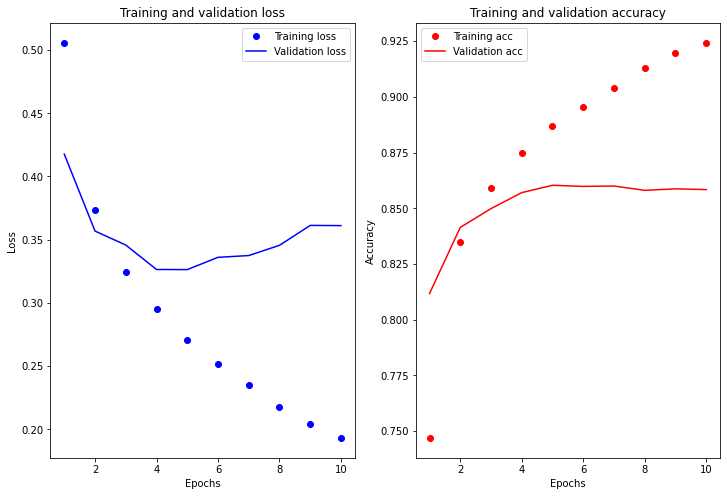

In [239]:
model_history_dict = model_history.history

acc = model_history_dict['accuracy']
val_acc = model_history_dict['val_accuracy']
loss = model_history_dict['loss']
val_loss = model_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [240]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3704 - accuracy: 0.8539
[0.37041404843330383, 0.8539373874664307]


-> 정확도가 85%이상 나오는 것을 확인할 수 있다!

# 프로젝트

## 배운점
1. 자연어 처리를 위해서는 embedding layer가 있어야 하며 이 embedding layer를 만드는 과정이 굉장히 어렵고 힘든 것이라는 것을 배웠다.
2. word for word in temp_X if not word in stopwords: temp_X의 크기만큼 for문이 반복되는데 만약 word가 wtopwords안에 없으면 word를 저장하는 코드이다. 한줄로 연결된 코드를 이해하기 처음에는 어려웠는데 반복해서 보다보니 이제 이해가 간다. 
3. toilist()란? 파이썬 내장 함수로 같은 라벨인 데이터끼리 묶는 것이다.  
4. collections 모듈의 Conter 사용법: 여러 형태의 데이터를 인자로 받는다. 먼저 중복된 데이터가 저장된 배열을 인자로 넘기면 각 원소가 몇 번씩 나오는지가 저장된 객체를 얻게 된다. most_common() 함수를 사용하면 가장 많이 나온 원소부터 순서대로 정렬해준다.  
5. Word2VecKeyedVectors 라이브러리의 gensim 모듈을 사용하면 단어벡터들 사이의 유사도를 분석하여 단어를 입력하면 가장 유사도가 높은 순서대로 출력해준다.   

## 아쉬운점
1. 어떤 모델을 써서 시도해보아도 과대적합이 나아지지 않았다. 드롭아웃이나 배치정규화를 시도하지 않았는데 다음에 이런것도 시도해서 성능을 더 높혀보고 싶다

## 종합의견
처음엔 내가 하고 있는 게 무엇이고 무엇을 위한 과정인지 이해하기 어려웠으나 사전학습된 한국어 임베딩 레이어를 가져와서 사용하여 자체학습한 임베딩 레이어 결과랑 비교하니 훨씬 성능이 좋아진 것을 보고 이해할 수 있었다. 

# Refernce
1. toilist()란? 같은 라벨인 데이터끼리 묶는 것이다.  
https://freedata.tistory.com/68  
2. collections 모듈의 Conter 사용법  
https://www.daleseo.com/python-collections-counter/  
3. 한국어 임베딩 방법  
https://wikidocs.net/50739  
4. 한국어 임베딩 방법  
https://omicro03.medium.com/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC-nlp-14%EC%9D%BC%EC%B0%A8-word2vec-%EC%8B%A4%EC%8A%B52-8e518a358b6c  
5. 한국어 임베딩 레이어 출처   
https://github.com/Kyubyong/wordvectors  